In [86]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import imageio.v2
import os

In [87]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [88]:
class Particle:
    def __init__(self, x, y, vx, vy, m, rad):
        self.m = m
        self.rad = rad

        self.x = x
        self.y = y

        self.vx = vx
        self.vy = vy
        self.pvx = 0
        self.pvy = 0

        self.forcex = 0
        self.forcey = 0

        self.px = 0
        self.py = 0

        self.nvx = 0
        self.nvy = 0

        self.potential = 0

        self.energy = 0
        self.kenergy = 0
        self.penergy = 0

        self.temperature = 0
        self.pressure = 0

    def change_position(self,x,y):
        self.x = x
        if self.x > 8.0:
            self.x -= 8.0
            self.px -= 8.0
        elif self.x < 0.0:
            self.x += 8.0
            self.px += 8.0

        self.y = y
        if self.y > 8.0:
            self.y -= 8.0
            self.py -= 8.0
        elif self.y < 0.0:
            self.y += 8.0
            self.py += 8

    def calculate_force(self, particles, eps, sigma):
        eps = eps
        sigma = sigma

        self.forcex = 0
        self.forcey = 0

        for p in particles:
            if p is not self:
                if abs(p.x - self.x) < abs(8 - self.x + p.x) and abs(p.x - self.x)<abs(8 + self.x - p.x):
                    distx = p.x - self.x

                elif abs(p.x - self.x) == abs(8 - self.x + p.x) or abs(p.x - self.x)==abs(8 + self.x - p.x):
                    distx = 0

                else:
                    if self.x < p.x:
                        distx = 8 + self.x - p.x
                        distx *= -1
                    else:
                        distx =  8 + p.x - self.x

                if abs(p.y - self.y) < abs(8 - self.y + p.y) and abs(p.y - self.y) < abs(8 + self.y - p.y):
                    disty = p.y - self.y

                elif abs(p.y - self.y) == abs(8 - self.y + p.y) or abs(p.y - self.y) == abs(8 + self.y - p.y):
                    disty = 0

                else:
                    if self.y < p.y:
                        disty = 8 + self.y - p.y
                        disty *= -1
                    else:
                        disty =  8 + p.y - self.y

                r = math.sqrt(distx**2 + disty**2)

                if (r <= 2.5 * sigma) and (r!=0):
                    self.forcex -= (48 * eps /(sigma**2)) * ((sigma/r)**14 - 0.5*(sigma/r)**8) * (distx)
                    self.forcey -= (48* eps /(sigma**2)) * ((sigma/r)**14 - 0.5*(sigma/r)**8) * (disty)

    def calculate_potential(self, particles):
        eps = 1.0
        sigma = 1.0
        self.potential = 0

        for p in particles:
            if p is not self:
                if abs(p.x - self.x) < abs(8 - self.x + p.x) and abs(p.x - self.x)<abs(8 + self.x - p.x):
                    distx = p.x - self.x
                else:
                    if self.x < p.x:
                        distx = 8 + self.x - p.x
                        distx *= -1
                    else:
                        distx =  8 + p.x - self.x

                if abs(p.y - self.y) < abs(8 - self.y + p.y) and abs(p.y - self.y)<abs(8 + self.y - p.y):
                    disty = p.y - self.y
                else:
                    if self.y < p.y:
                        disty = 8 + self.y - p.y
                        disty *= -1
                    else:
                        disty =  8 + p.y - self.y

                r = math.sqrt(distx**2 + disty**2)
                if r <= 2.5 * sigma:
                    self.potential += 4 * eps * ((sigma/r)**12 - (sigma/r)**6)
                    self.potential -= 4 * eps * ((sigma/(2.5*sigma))**12 - (sigma/(2.5*sigma))**6)

    def calculate_energy(self):
        v2 = self.nvx**2 + self.nvy**2
        self.kenergy = (self.m * v2)/2
        self.penergy = (self.potential * self.m)/2
        self.energy = self.kenergy + self.penergy

    def calculate_pressure(self, particles, NParticle, ASize, eps, sigma):
        eps = eps
        sigma = sigma
        virial = 0

        self.pressure = 0

        for p in particles:
            if p is not self:
                if abs(p.x - self.x) < abs(8 - self.x + p.x) and abs(p.x - self.x)<abs(8 + self.x - p.x):
                    distx = p.x - self.x

                elif abs(p.x - self.x) == abs(8 - self.x + p.x) or abs(p.x - self.x)==abs(8 + self.x - p.x):
                    distx = 0

                else:
                    if self.x < p.x:
                        distx = 8 + self.x - p.x
                        distx *= -1
                    else:
                        distx =  8 + p.x - self.x

                if abs(p.y - self.y) < abs(8 - self.y + p.y) and abs(p.y - self.y) < abs(8 + self.y - p.y):
                    disty = p.y - self.y

                elif abs(p.y - self.y) == abs(8 - self.y + p.y) or abs(p.y - self.y) == abs(8 + self.y - p.y):
                    disty = 0

                else:
                    if self.y < p.y:
                        disty = 8 + self.y - p.y
                        disty *= -1
                    else:
                        disty =  8 + p.y - self.y

                r = math.sqrt(distx**2 + disty**2)

                if (r <= 2.5 * sigma) and (r!=0):
                    forcex = (48 * eps /(sigma**2)) * ((sigma/r)**14 - 0.5*(sigma/r)**8) * (distx)**2
                    forcey = (48* eps /(sigma**2)) * ((sigma/r)**14 - 0.5*(sigma/r)**8) * (disty)
                    force = math.sqrt(forcex**2 + forcey**2)
                    virial += (force * r)

        V = ASize * ASize
        self.pressure = (NParticle * kB * self.temperature) / V
        self.pressure += (1/(2*V) * virial)

In [89]:
#Simulation parameters
particleNumber = 16
areaSize = 8
eps = 1.0
sigma = 1.0
radius = sigma/2
dt = 0.0001
kB = 1
m = 1
Text = 0.1

In [90]:
#Generating starting positions and velocities
cords = []
for i in range (1,areaSize,2):
    for j in range (1,areaSize,2):
        cords.append([j,i])

vs=[]
for i in range (particleNumber):
    if random.randint(0,1): x=1
    else: x=-1

    if  random.randint(0,1): y=1
    else: y=-1

    vs.append([x*random.random(), y*random.random()])

In [91]:
#Generating particles and adding them to a list
Particles = []
for i in range(particleNumber):
    Particles.append(Particle(cords[i][0], cords[i][1], vs[i][0], vs[i][1], m, radius))

In [92]:
#Removing center of mass velocity
sumvMassX = 0
sumvMassY = 0

for p in Particles:
    sumvMassX += p.vx
    sumvMassY += p.vy

vMassX = sumvMassX / particleNumber
vMassY = sumvMassY / particleNumber

for p in Particles:
    p.vx = p.vx - vMassX
    p.vy = p.vy - vMassY

In [93]:
#Scaling velocities to required temperature
v2_sum= 0
kineticEnergy = 0

for p in Particles:
    v2 = (p.vx**2 + p.vy**2)
    kineticEnergy += (v2 * m)/2

kineticEnergy_avg = kineticEnergy

vscale = math.sqrt(kineticEnergy_avg/(kB* particleNumber * Text))

for p in Particles:
    p.vx = p.vx / vscale
    p.vy = p.vy / vscale

v2sum=0
for p in Particles:
    v2sum += (p.vx**2 + p.vy**2)

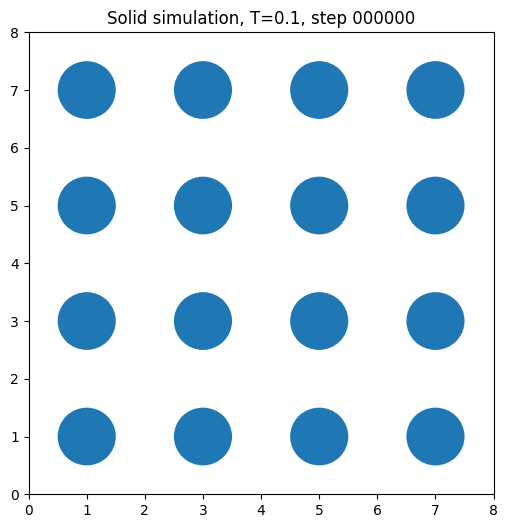

In [94]:
#Ploting the first frame
filenames = []
plt.clf()
fig = plt.gcf()
for p in Particles:
    a = plt.gca()
    cir = Circle((p.x, p.y), radius = p.rad)
    a.add_patch(cir)
    plt.plot()
plt.xlim((0, areaSize))
plt.ylim((0, areaSize))
fig.set_size_inches((6, 6))
plt.title(f'Solid simulation, T={Text}, step {0:06d}')
filenames.append(f'/content/gdrive/MyDrive/5SEM/SIM/images/Solid/img{0:06d}.png')
plt.savefig(f'/content/gdrive/MyDrive/5SEM/SIM/images/Solid/img{0:06d}.png')

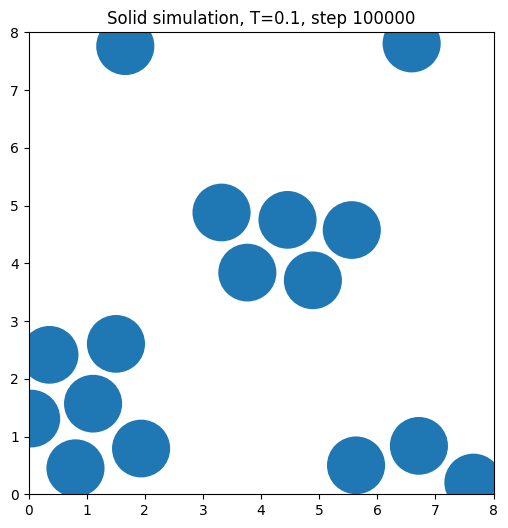

In [95]:
#Time loop
iteration = 0
i = 0
tempertaures = []
pressures = []
totalEnergies = []
TimeStamps = []

for p in Particles:
    p.px = p.x - p.vx * dt
    p.py = p.y - p.vy * dt

for t in np.arange(0, 10, dt):
    iteration += 1
    i +=1

    for p in Particles:
        p.calculate_force(Particles, eps, sigma)

    for p in Particles:
        #Make an unconstrained half step
        p.pvx = (p.x - p.px)/dt
        p.pvy = (p.y - p.py)/dt

        p.nvx = p.pvx + (p.forcex/p.m) * dt/2
        p.nvy = p.pvy + (p.forcey/p.m) * dt/2

        p.px = p.x
        p.py = p.y

    for p in Particles:
        p.calculate_potential(Particles)
        p.calculate_energy()

    totalEnergy= 0
    for p in Particles:
        totalEnergy += p.energy

    totalEnergies.append(totalEnergy)

    kineticEnergy = 0
    v2sum = 0
    temps = 0
    for p in Particles:
        p.temperature = 2/(2 * kB) * p.kenergy
        temps += p.temperature

    #Calculate the instantaneous temperature
    temperature = temps/(particleNumber)
    tempertaures.append(temperature)

    press = 0

    for p in Particles:
        p.calculate_pressure(Particles, particleNumber, areaSize, eps, sigma)
        press += p.pressure

    pressure = press/(particleNumber)
    pressures.append(pressure)

    #Calculate the eta coefficient
    eta = np.sqrt(Text/temperature)

    for p in Particles:

        #complete the full leapfrog step
        p.nvx = (2 * eta - 1) * p.pvx + eta * (p.forcex/p.m) * dt
        p.nvy = (2 * eta - 1) * p.pvy + eta * (p.forcey/p.m) * dt

    #save frames
    if iteration == 100:
        plt.clf()
        fig = plt.gcf()
        for p in Particles:
            a = plt.gca()
            cir = Circle((p.x, p.y), radius = p.rad)
            a.add_patch(cir)
            plt.plot()
        plt.xlim((0, areaSize))
        plt.ylim((0, areaSize))
        fig.set_size_inches((6, 6))
        plt.title(f'Solid simulation, T={Text}, step {i:06d}')
        filenames.append(f'/content/gdrive/MyDrive/5SEM/SIM/images/Solid/img{i:06d}.png')
        plt.savefig(f'/content/gdrive/MyDrive/5SEM/SIM/images/Solid/img{i:06d}.png')
        iteration = 0



    TimeStamps.append(t)

    for p in Particles:
        p.change_position(p.x + p.nvx*dt, p.y + p.nvy*dt)

<Figure size 640x480 with 0 Axes>

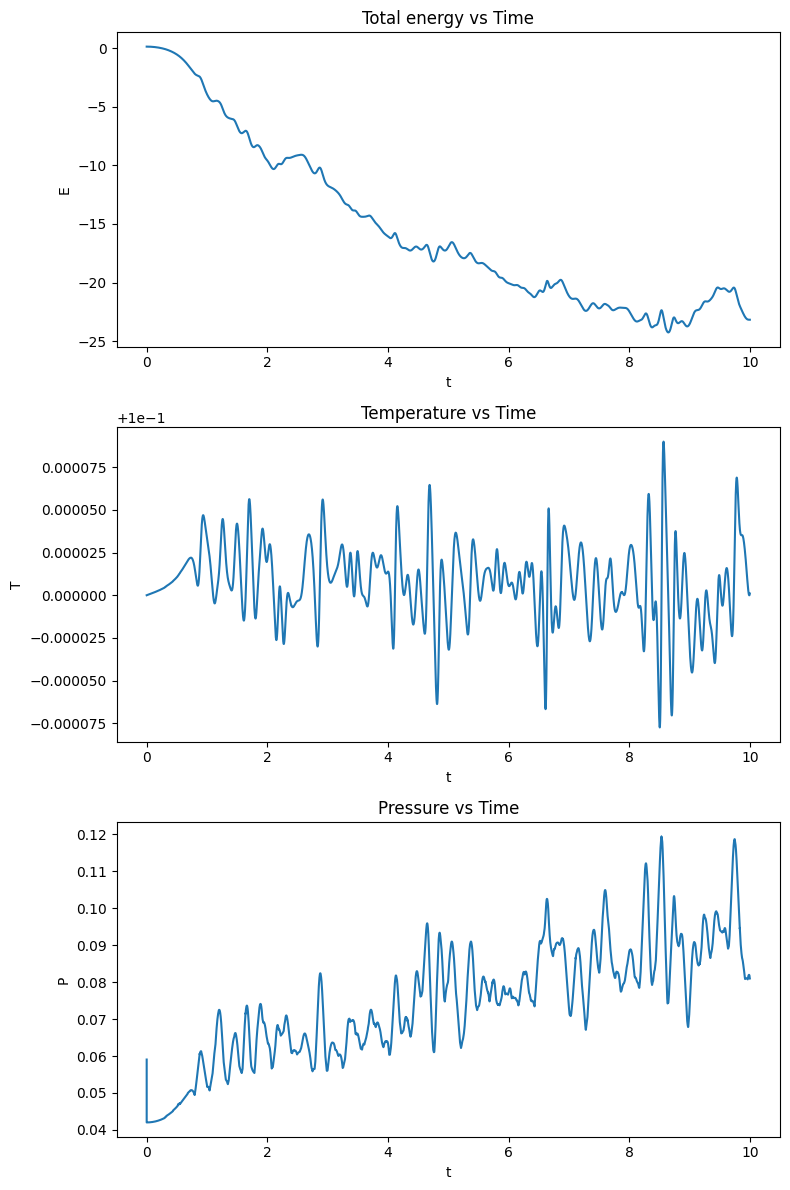

In [96]:
plt.clf()
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot for totalEnergies
axs[0].plot(TimeStamps, totalEnergies)
axs[0].set(xlabel="t", ylabel="E")
axs[0].set_title("Total energy vs Time")

# Plot for tempertaures
axs[1].plot(TimeStamps, tempertaures)
axs[1].set(xlabel="t", ylabel="T")
axs[1].set_title("Temperature vs Time")

# Plot for pressures
axs[2].plot(TimeStamps, pressures)
axs[2].set(xlabel="t", ylabel="P")
axs[2].set_title("Pressure vs Time")

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Save the figure
plt.savefig("/content/gdrive/MyDrive/5SEM/SIM/images/ThermostatPlots/combined_plot.png")

# Show the plot
plt.show()

#Make a gif
with imageio.get_writer('/content/gdrive/MyDrive/5SEM/SIM/images/Solid/movie.gif', mode='I') as writer:
    for filename in filenames:
      try:
        image = imageio.v2.imread(filename)
        writer.append_data(image)
        os.remove(filename)
      except FileNotFoundError:
          continue